<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#pytorch代码结构" data-toc-modified-id="pytorch代码结构-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>pytorch代码结构</a></span><ul class="toc-item"><li><span><a href="#源代码结构" data-toc-modified-id="源代码结构-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>源代码结构</a></span></li><li><span><a href="#调用链路" data-toc-modified-id="调用链路-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>调用链路</a></span></li></ul></li><li><span><a href="#转换关系" data-toc-modified-id="转换关系-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>转换关系</a></span></li><li><span><a href="#映射方法：为-ATen-算子添加符号函数" data-toc-modified-id="映射方法：为-ATen-算子添加符号函数-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>映射方法：为 ATen 算子添加符号函数</a></span></li><li><span><a href="#映射方法：为-TorchScript-算子添加符号函数" data-toc-modified-id="映射方法：为-TorchScript-算子添加符号函数-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>映射方法：为 TorchScript 算子添加符号函数</a></span></li><li><span><a href="#添加torch.autograd.Function算子，并增加映射" data-toc-modified-id="添加torch.autograd.Function算子，并增加映射-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>添加torch.autograd.Function算子，并增加映射</a></span></li><li><span><a href="#自定义pytorch-C++算子" data-toc-modified-id="自定义pytorch-C++算子-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>自定义pytorch C++算子</a></span></li><li><span><a href="#onnx函数：onnx-script" data-toc-modified-id="onnx函数：onnx-script-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>onnx函数：onnx-script</a></span></li><li><span><a href="#参考" data-toc-modified-id="参考-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>参考</a></span></li></ul></div>

In [5]:
# from torch.onnx.symbolic_registry import register_op ---> error 
from torch.onnx import register_custom_op_symbolic

In [6]:
import torch
from torch import nn

In [7]:
import onnxruntime as ort

## pytorch代码结构

### 源代码结构

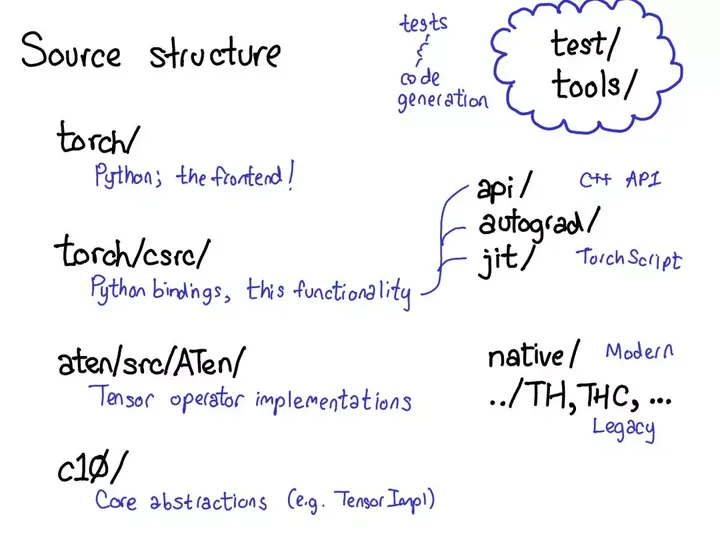

torch的源代码中最重要的几个部分：
+ torch: 平常使用时看到的torch接口、类和函数等
+ torch/csrc: pybinding相关代码，绑定过了pytorch接口和C++接口，包括api、jit和autograd等
+ aten/src/ATen: C++实现的张量计算库，我们在torch前端用到的很多计算函数或者说算子，其实绝大部分在底层都是用aten实现的。包括现代C++实现和原生C实现（比如TH、THC、THNN和THCUNN等）
+ C10: pytorch的和核心抽象

### 调用链路

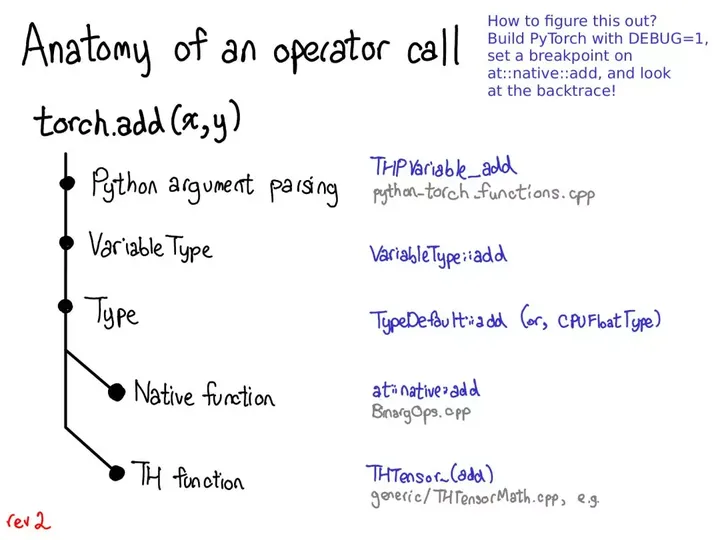

当我们在前端调用torch.add方法时，最终调用的是底层C++在ATen实现的Add算子，整个过程大致如下（使用1.13.1版本，不同版本实现有差异）：
+ 在python侧调用torch.add时会执行torch目录下的`__init__.py`文件，该文件中将从`_C/_VariableFunctions.pyi`文件中导入add函数。`_C/_VariableFunctions`里面包含了使用C++实现的函数。
```python
for name in dir(_C._VariableFunctions):
    if name.startswith('__') or name in PRIVATE_OPS:
        continue
    obj = getattr(_C._VariableFunctions, name)
    obj.__module__ = 'torch'
    # Hide some APIs that should not be public
    if name == "segment_reduce":
        # TODO: Once the undocumented FC window is passed, remove the line bellow
        globals()[name] = obj
        name = "_" + name
    globals()[name] = obj
    if not name.startswith("_"):
        __all__.append(name)
```

+ `_C._VaraibleFunctions`是由pybinding将python和C++进行绑定时定义的名称，其中`torch._C`表示整个C++模块，`_VaraibleFunctions`代表C++实现的函数：
``` python
# torch/csrc/Module.cpp
static struct PyModuleDef torchmodule = {
    PyModuleDef_HEAD_INIT, "torch._C", nullptr, -1, methods.data()};
ASSERT_TRUE(module = PyModule_Create(&torchmodule));
  
# torch/csrc/autograd/python_torch_functions_manual.cpp
THPVariableFunctionsModule =
      PyType_GenericNew(&THPVariableFunctions, Py_None, Py_None);
  // PyModule_AddObject steals a reference
  if (PyModule_AddObject(
          module, "_VariableFunctions", THPVariableFunctionsModule) < 0) {
    throw python_error();
  }
```
    
+ _VariableFunctions中的函数会在编译pytorch的时候搜索对应函数并注册：



```python

# tools/autograd/templates/python_torch_functions.cpp
// generated methods start here

${py_methods}  # py_methods这个变量按照下面的实现展开

# tools/autograd/gen_python_functions.py
for name in sorted(grouped.keys(), key=lambda x: str(x)):
    overloads = grouped[name]
    py_methods.append(
        method_impl(name, module, overloads, method=method, symint=symint)
    )
    py_method_defs.append(method_def(name, module, overloads, method=method))
    py_forwards.extend(forward_decls(name, overloads, method=method))
    ops_headers.append(f"#include <ATen/ops/{name.base}.h>")  # 可以看到对应的头文件是ATen里面的算子定义

fm.write_with_template(
    filename,
    filename,
    lambda: {
        "generated_comment": "@"
        + f"generated from {fm.template_dir_for_comments()}/{filename}",
        "ops_headers": ops_headers,
        "py_forwards": py_forwards,
        "py_methods": py_methods,
        "py_method_defs": py_method_defs,
    },
)  


# torch/csrc/autograd/python_torch_functions_manual.cpp
# 最终调用的THPVariable_add这个函数
#define THPVARIABLE_SPARSE_COMPRESSED_CTOR(NAME, NARGS, SIGNATURES)       \
  static PyObject* THPVariable_##NAME(                                    \
      PyObject* self, PyObject* args, PyObject* kwargs) {                 \
    HANDLE_TH_ERRORS                                                      \
    static PythonArgParser parser SIGNATURES;                             \
    ParsedArgs<NARGS> parsed_args;                                        \
    auto r = parser.parse(args, kwargs, parsed_args);                     \
    if (r.has_torch_function()) {                                         \
      return handle_torch_function(                                       \
          r, nullptr, args, kwargs, THPVariableFunctionsModule, "torch"); \
    }                                                                     \
    jit::tracer::warn("torch." #NAME, jit::tracer::WARN_CONSTRUCTOR);     \
    return THPVariable_Wrap(torch::utils::NAME##_ctor(                    \
        torch::tensors::get_default_dispatch_key(),                       \
        torch::tensors::get_default_scalar_type(),                        \
        r));                                                              \
    END_HANDLE_TH_ERRORS                                                  \
  }
```

+ 绑定的函数会在`torch/_C/_VariableFunctions.pyi`中提供函数接口定义（或者存根程序）。类似的，对于`torch.nn.functional`中的函数实际也是类似实现，其会在`torch/nn/functional.pyi`中提供函数接口定义。而这两个`.pyi`文件是在编译torch时生成的

## 转换关系

> 而要使 PyTorch 算子顺利转换到 ONNX ，我们需要保证以下三个环节都不出错：
> + 算子在 PyTorch 中有实现
> + 有把该 PyTorch 算子映射成一个或多个 ONNX 算子的方法
> + ONNX 有相应的算子
> 可在实际部署中，这三部分的内容都可能有所缺失。其中最坏的情况是：我们定义了一个全新的算子，它不仅缺少 PyTorch 实现，还缺少 PyTorch 到 ONNX 的映射关系。但所谓车到山前必有路，对于这三个环节，我们也分别都有以下的添加支持的方法：

> + PyTorch 算子
> - 组合现有算子
> - 添加 TorchScript 算子
> - 添加普通 C++ 拓展算子
> + 映射方法
> - 为 ATen 算子添加符号函数
> - 为 TorchScript 算子添加符号函数
> - 封装成 torch.autograd.Function 并添加符号函数
> + ONNX 算子
> - 使用现有 ONNX 算子
> - 定义新 ONNX 算子

## 映射方法：为 ATen 算子添加符号函数

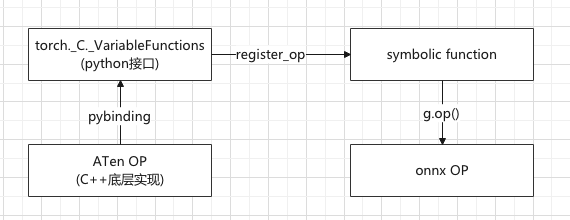

+ ATen算子通过pybinding提供对外的python接口，并且展示算子接口（类似forward函数）
+ 通过register_op注册ATen算子对应的符号函数
+ 在符号函数中，通过g.op绑定对应的onnx算子
+ torch中各个算子的符号函数在`torch/onnx/symbolic_opset{x}.py`文件中定义

```python
@_onnx_symbolic("aten::add")
@_beartype.beartype
def add(g: jit_utils.GraphContext, self, other, alpha=None):
    if symbolic_helper._is_value(self) and symbolic_helper._is_tensor_list(self):
        return symbolic_helper._onnx_opset_unsupported_detailed(
            "Add", 9, 11, "Add between list of tensors not supported", self
        )
    if alpha and symbolic_helper._scalar(symbolic_helper._maybe_get_scalar(alpha)) != 1:
        other = g.op("Mul", other, alpha)
    return g.op("Add", self, other)
```

下面使用asinh函数作为例子，展示如何自定义ATen算子和onnx算子映射。
+ 首先确定该算子在ATen中是否已经实现，在`torch/_C/_VariableFunctions.pyi`中可以查找到该算子的接口定义，说明已经实现：
```python
def asinh(input: Tensor, *, out: Optional[Tensor]=None) -> Tensor: ...
```

+ 接着，确保该算子在ONNX中已经实现，查看onnx的[官方文档](https://onnx.ai/onnx/operators/onnx__Asinh.html)发现该算子已经实现，并且是在`opset_version 9`时新增

+ 接下来定义符号函数和注册算子即可


In [7]:
def asinh_symbolic(g, inx, *, out=None):  # 接口需要与torch/_C/_VariableFunctions中的接口一致
    return g.op("Asinh", inx)  # Asinh为onnx算子名称

# asinh为在torch中的算子名称，新版本需要指定domain，这里指定为aten，指定版本号为9
register_custom_op_symbolic("aten::asinh", asinh_symbolic, 9) 

In [6]:
class AsinhModel(nn.Module):
    def forward(self, x):
        return torch.asinh(x)

model = AsinhModel()

In [7]:
input_x = torch.rand(2, 3)
model(input_x)

tensor([[0.4458, 0.1826, 0.8013],
        [0.1616, 0.3990, 0.5071]])

In [9]:
torch.onnx.export(model, input_x, "asinh_op.onnx", input_names=["input"], opset_version=9)

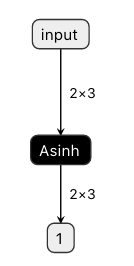

In [13]:
ort_session = ort.InferenceSession("asinh_op.onnx")
ort_session.run(None, {"input": input_x.numpy()})

[array([[0.82604593, 0.34178743, 0.50345725],
        [0.2323745 , 0.41694668, 0.43999675]], dtype=float32)]

## 映射方法：为 TorchScript 算子添加符号函数

TorchScript是torch提出的一种类似onnx的中间表示格式，torch模型可以转换为TorchScriptModel格式，并且从C++/python加载。当ATen中没有对应算子时，可以考虑自定义TorchScript算子。但是torch官方更推荐使用ATen算子来实现:
> Nevertheless, there may be times where you find yourself in need of extending TorchScript with a custom C++ or CUDA function. While we recommend that you only resort to this option if your idea cannot be expressed (efficiently enough) as a simple Python function, we do provide a very friendly and simple interface for defining custom C++ and CUDA kernels using ATen, PyTorch’s high performance C++ tensor library.

下面以可变形卷积为例说明如何将TorchScript算子映射到onnx算子中。

+ 首先，可变形卷积在torchvision中定义如下，可以发现python前端和C++后端中该算子的参数不一致，在定义符号函数的时候需要与C++的保持一致：
```python

# python
torchvision.ops.deform_conv2d(input: Tensor, offset: Tensor, weight: Tensor, bias: Optional[Tensor] = None, stride: Tuple[int, int] = (1, 1), padding: Tuple[int, int] = (0, 0), dilation: Tuple[int, int] = (1, 1), mask: Optional[Tensor] = None) → Tensor
```

```C++

# C++: torchvision/csrc/ops/deform_conv2d.cpp
TORCH_LIBRARY_FRAGMENT(torchvision, m) {
  m.def(TORCH_SELECTIVE_SCHEMA(
      "torchvision::deform_conv2d(Tensor input, Tensor weight, Tensor offset, Tensor mask, Tensor bias, int stride_h, int stride_w, int pad_h, int pad_w, int dilation_h, int dilation_w, int groups, int offset_groups, bool use_mask) -> Tensor"));
}


```

+ 其次，从version19之后onnx开始支持可变形卷积，对应算子为：`DeformConv`

![image.png](attachment:image.png)![%E6%88%AA%E5%B1%8F2023-06-16%2019.43.04.png](attachment:%E6%88%AA%E5%B1%8F2023-06-16%2019.43.04.png)

In [4]:
from torch.onnx.symbolic_helper import parse_args

In [13]:
# 符号函数的输入参数与C++中定义的保持一致
@parse_args("v", "v", "v", "v", "v", "i", "i", "i", "i", "i", "i", "i", "i", "none") 
def deformable_conv_symbolic(g, inx, weight, offset, mask, bias, stride_h, stride_w, pad_h, pad_w, dilation_h, dilation_w, groups, offset_groups, use_mask):
    # 需要与ONNX中定义的算子输入保持一致
    return g.op("custom::deform_conv2d", inx, weight, offset)

register_custom_op_symbolic("torchvision::deform_conv2d", deformable_conv_symbolic, 9)

> 这段代码中，最令人疑惑的就是装饰器 @parse_args 了。简单来说，TorchScript 算子的符号函数要求标注出每一个输入参数的类型。比如"v"表示 Torch 库里的 value 类型，一般用于标注张量，而"i"表示 int 类型，"f"表示 float 类型，"none"表示该参数为空。具体的类型含义可以在 torch.onnx.symbolic_helper.py (https://github.com/pytorch/pytorch/blob/master/torch/onnx/symbolic_helper.py)中查看。

In [6]:
input_x = torch.rand(4, 3, 10, 10)
kh, kw = 3, 3
weight = torch.rand(5, 3, kh, kw)
offset = torch.rand(4, 2 * kh * kw, 8, 8)

In [7]:
import torchvision

In [8]:
class DeformableConvModel(nn.Module):
    def forward(self, x, offset, weight):
        return torchvision.ops.deform_conv2d(x, offset, weight)

model = DeformableConvModel()
out_torch = model(input_x, offset, weight)

In [14]:
torch.onnx.export(model, (input_x, offset, weight), "deform_conv2d.onnx", 
                  input_names=["input", "offset", "weight"])

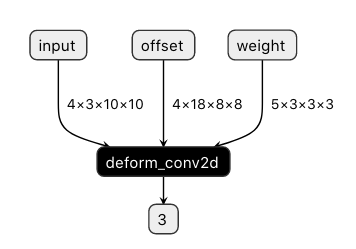

In [15]:
ort_session = ort.InferenceSession("deform_conv2d.onnx")
ort_session.run(None, {"input": input_x.numpy(), "offset": offset.numpy(), "weight": weight.numpy()})

Fail: [ONNXRuntimeError] : 1 : FAIL : Load model from deform_conv2d.onnx failed:Fatal error: custom:deform_conv2d(-1) is not a registered function/op

我们在注册时候写的`custom::deform_conv2d`算子实际上并没有实现，所以这里找不到具体的实现算子，所以是无法解析和运行的。

## 添加torch.autograd.Function算子，并增加映射

新增TorchScript算子比较复杂，而更常用的方式是添加`torch.autograd.Function`算子。`torch.autograd.Function`是一种自定义算子的扩展方式，在python前端继承`torch.autograd.Function`并实现`forward`和`backward`方法，来完成前向计算和后向求导功能。这意味着如果我们需要用该算子来训练，则必须实现`forward`和`backward`函数，但是由于现在只需要做推理，所以`backward`函数可以不实现。

In [17]:
class MyAddPyOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b):
        return 2 * a + b
    
    @staticmethod
    def symbolic(g, a, b):
        two = g.op("Constant", value_t=torch.tensor([2]))
        c = g.op("Mul", two, a)
        return g.op("Add", c, b)
        

> 对模型部署来说，Function 类有一个很好的性质：如果它定义了 symbolic 静态方法，该 Function 在执行 torch.onnx.export() 时就可以根据 symbolic 中定义的规则转换成 ONNX 算子。这个 symbolic 就是前面提到的符号函数，只是它的名称必须是 symbolic 而已。

In [20]:
input_x = torch.ones(2, 3)
input_y = torch.zeros(2, 3)

In [21]:
class MyAddPyOpModel(nn.Module):
    def forward(self, x, y):
        return MyAddPyOp.apply(x, y)

model = MyAddPyOpModel()
model(input_x, input_y)

tensor([[2., 2., 2.],
        [2., 2., 2.]])

In [22]:
torch.onnx.export(model, (input_x, input_y), "my_add_op_py.onnx", input_names=["inputx", "inputy"])

/Users/yangqj/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 'torch.onnx._patch_torch._graph_op' is deprecated in version 1.13 and will be removed in version 1.14. Please note 'g.op()' is to be removed from torch.Graph. Please open a GitHub issue if you need this functionality..
  
/Users/yangqj/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 'torch.onnx._patch_torch._graph_op' is deprecated in version 1.13 and will be removed in version 1.14. Please note 'g.op()' is to be removed from torch.Graph. Please open a GitHub issue if you need this functionality..
  if __name__ == "__main__":
/Users/yangqj/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 'torch.onnx._patch_torch._graph_op' is deprecated in version 1.13 and will be removed in version 1.14. Please note 'g.op()' is to be removed from torch.Graph. Please open a GitHub issue if you need this functionality..
 

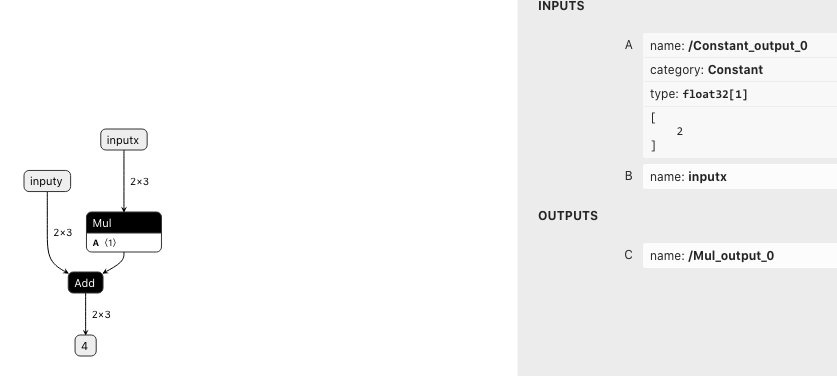

In [23]:
ort_session = ort.InferenceSession("my_add_op_py.onnx")
ort_session.run(None, {"inputx": input_x.numpy(), "inputy": input_y.numpy()})

[array([[2., 2., 2.],
        [2., 2., 2.]], dtype=float32)]

## 自定义pytorch C++算子

首先在C++中定义my_add函数，并通过pybind绑定python接口和C++函数：my_lib对应python中要导入的模块，my_add对应python要使用的函数名：
```C++
from setuptools import setup
from torch.utils import cpp_extension

setup(name="my_add",
      ext_modules=[cpp_extension.CppExtension("my_lib", ["my_add_op.cpp"])],
      cmdclass={"build_ext": cpp_extension.BuildExtension},
      include_dirs=["/Library/Developer/CommandLineTools/usr/include/c++/v1"]
     )


```

In [2]:
!cat my_add_op.cpp

#include <torch/torch.h>

torch::Tensor my_add(torch::Tensor a, torch::Tensor b) {
    return 2 * a + b;
}

PYBIND11_MODULE(my_lib, m) {
    m.def("my_add", my_add);
}



使用setup.py编译cpp文件得到my_lib.so动态库：
```python
from setuptools import setup
from torch.utils import cpp_extension

setup(name="my_add",
      ext_modules=[cpp_extension.CppExtension("my_lib", ["my_add_op.cpp"])],
      cmdclass={"build_ext": cpp_extension.BuildExtension},
      include_dirs=["/Library/Developer/CommandLineTools/usr/include/c++/v1"]
     )


```

在python中调用my_lib模块中的my_add函数：

```python
import my_lib

class MyAddPyOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b):
        return my_lib.my_add(a, b)
    
    @staticmethod
    def symbolic(g, a, b):
        two = g.op("Constant", value_t=torch.tensor([2]))
        c = g.op("Mul", two, a)
        return g.op("Add", c, b)
        
```

## onnx函数：onnx-script

如果一个算子并不是onnx自有算子，但是可以用多个onnx算子组合得到，那么可以使用onnx-script工具组装一个onnx算子：
> If an operator is not a standard ONNX op, but can be composed of multiple existing ONNX ops, you can utilize ONNX-script to create an external ONNX function to support the operator.


In [4]:
!pip install onnxscript

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement onnxscript (from versions: none)
ERROR: No matching distribution found for onnxscript


In [ ]:
import onnxscript
from onnxscript.onnx_opset import opset14 as op

In [8]:
opset_version = 14

In [ ]:
custom_opset = onnxscript.values.Opset(domain="custom-onnx-script", version=1)

@onnxscript.script(custom_opset)
def Selu(X):
    alpha = 1.67326
    gamma = 1.0507
    alphaX = op.CastLike(alpha, X)
    gammaX = op.CastLike(gamma, X)
    neg = gammaX * (alphaX * op.Exp(X) - alphaX)
    pos = gammaX * X
    zeroX = op.CastLike(0, X)
    return op.Where(X <= zeroX, neg, pos)


def selu_symbolic(g, x):
    return g.onnxscript_op(Selu, x).setType(x.type())

register_custom_op_symbolic("aten::selu", selu_symbolic, opset_version)

In [ ]:
model = torch.nn.SELU()
x = torch.randn(2, 3)
torch.onnx.export(model, x, "onnxscript_op.onnx", 
                  opset_version=opset_version, 
                  custom_opsets={"custom-onnx-script": 1})

## 参考

+ https://zhuanlan.zhihu.com/p/67834038
+ https://zhuanlan.zhihu.com/p/107160949
+ https://www.zhihu.com/column/c_1497987564452114432
+ https://pytorch.org/tutorials/advanced/torch_script_custom_ops.html
+ 可变形卷积：https://zhuanlan.zhihu.com/p/335147713
+ torch.autograd: [1](https://blog.csdn.net/qq_27825451/article/details/95189376?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522168692154316800226548893%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fblog.%2522%257D&request_id=168692154316800226548893&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~blog~first_rank_ecpm_v1~rank_v31_ecpm-13-95189376-null-null.268^v1^koosearch&utm_term=pytorch&spm=1018.2226.3001.4450), [2](https://zhuanlan.zhihu.com/p/344802526)